In [2]:
pip install numpy pandas matplotlib seaborn scikit-learn tensorflow keras


In [8]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import os, os.path
import tensorflow.keras.layers as layers
import tensorflow.keras as keras
import sklearn
import sklearn.model_selection
import random
import kagglehub

In [4]:
!pip install kagglehub

In [5]:
XRAY_IMG_SIZE = (162,300) # Constant values for the size of the image and batch_size
BATCH_SIZE = 128

In [9]:
path = kagglehub.dataset_download("orvile/digital-knee-x-ray-images")

print("Path to dataset files:", path)

100%|██████████| 117M/117M [00:00<00:00, 201MB/s]


Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/orvile/digital-knee-x-ray-images/versions/2


In [13]:
current_dir = '/root/.cache/kagglehub/datasets/orvile/digital-knee-x-ray-images/versions/2'
image_dir = current_dir + '/' + 'Digital Knee X-ray Images' + '/' + 'Digital Knee X-ray Images' + '/' + 'Knee X-ray Images'
# Locate the main directory containg the images

In [14]:
from PIL import Image
from tensorflow.keras.applications.resnet import preprocess_input

def get_Xrays_resnet(grade, main_dir, expert_num):
    X_rays = []

    # Build path based on expert
    if expert_num == 1:
        Xray_dir = os.path.join(main_dir, 'MedicalExpert-I', 'MedicalExpert-I')
    else:
        Xray_dir = os.path.join(main_dir, 'MedicalExpert-II', 'MedicalExpert-II')

    # Append grade folder
    grade_folder_map = {
        0: '0Normal',
        1: '1Doubtful',
        2: '2Mild',
        3: '3Moderate',
        4: '4Severe'
    }
    Xray_dir = os.path.join(Xray_dir, grade_folder_map[grade])

    for pic in os.listdir(Xray_dir):
        img_path = os.path.join(Xray_dir, pic)
        try:
            img = Image.open(img_path).convert("RGB")
            img = img.resize((224, 224))  # Required for ResNet
            img = np.array(img)
            img = preprocess_input(img)   # ResNet-specific normalization
            X_rays.append(img)
        except Exception as e:
            print(f"Skipped {img_path}: {e}")

    return np.array(X_rays)  # Return a NumPy array, ready for model input


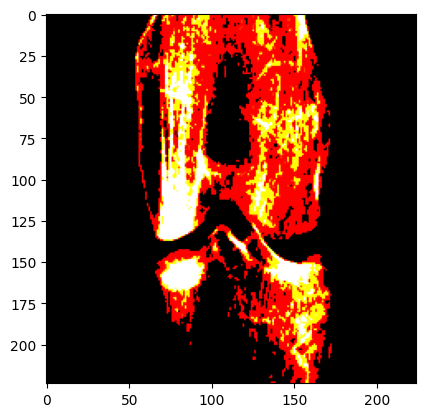

In [15]:
a = get_Xrays_resnet(1, image_dir, 1)
plt.imshow(a[19])
#print(tf.shape(a[1]))

In [16]:
def load_all_Xrays_resnet():
    X = []
    y = []

    for expert_num in [1, 2]:
        for grade in range(5):  # 0 to 4
            x_data = get_Xrays_resnet(grade, image_dir, expert_num)
            X.extend(x_data)
            y.extend([grade] * len(x_data))  # Assign label

    X = np.array(X)
    y = np.array(y)
    return X, y


In [17]:
X, y = load_all_Xrays_resnet()

# Check shapes
print("Images:", X.shape)  # e.g., (N, 224, 224, 3)
print("Labels:", y.shape)  # e.g., (N,)


Images: (3300, 224, 224, 3)
Labels: (3300,)


In [18]:
from sklearn.utils import shuffle

X_shuffled, y_shuffled = shuffle(X, y, random_state=50)


In [19]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# 👇 Use raw label values (e.g., 0, 1, 2, 3, 4)
X_train, X_pre_test, y_train, y_pre_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=50
)

X_dev, X_test, y_dev, y_test = train_test_split(
    X_pre_test, y_pre_test, test_size=0.5, stratify=y_pre_test, random_state=50
)

# 👇 Then one-hot encode after splitting
y_train = to_categorical(y_train, num_classes=5)
y_dev   = to_categorical(y_dev, num_classes=5)
y_test  = to_categorical(y_test, num_classes=5)


In [20]:
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_dev:", X_dev.shape)
print("y_dev:", y_dev.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)


X_train: (2310, 224, 224, 3)
y_train: (2310, 5)
X_dev: (495, 224, 224, 3)
y_dev: (495, 5)
X_test: (495, 224, 224, 3)
y_test: (495, 5)


In [21]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(5, activation='softmax')(x)  # 5 classes

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,629 (90.98 MB)

 Trainable params: 262,917 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [22]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_dev, y_dev),
    epochs=10,
    batch_size=32
)


Epoch 1/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 533s 7s/step - accuracy: 0.2337 - loss: 2.5211 - val_accuracy: 0.3798 - val_loss: 1.2960
Epoch 2/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 501s 6s/step - accuracy: 0.3764 - loss: 1.5875 - val_accuracy: 0.5212 - val_loss: 1.1412
Epoch 3/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 454s 6s/step - accuracy: 0.4207 - loss: 1.4020 - val_accuracy: 0.5879 - val_loss: 1.0973
Epoch 4/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 499s 6s/step - accuracy: 0.4468 - loss: 1.3256 - val_accuracy: 0.5960 - val_loss: 1.0409
Epoch 5/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 504s 6s/step - accuracy: 0.5008 - loss: 1.2185 - val_accuracy: 0.5717 - val_loss: 1.0143
Epoch 6/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 499s 6s/step - accuracy: 0.5217 - loss: 1.1409 - val_accuracy: 0.5899 - val_loss: 0.9663
Epoch 7/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 450s 6s/step - accuracy: 0.5061 - loss: 1.1284 - val_accuracy: 0.6202 - val_loss: 0.9435
Epoch 8/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 499s 6s/step - accuracy: 0.5462 - loss: 1.0809 - val_accuracy: 0.6747 - v

In [23]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.2f}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 85s 5s/step - accuracy: 0.6889 - loss: 0.9035
Test Accuracy: 0.68


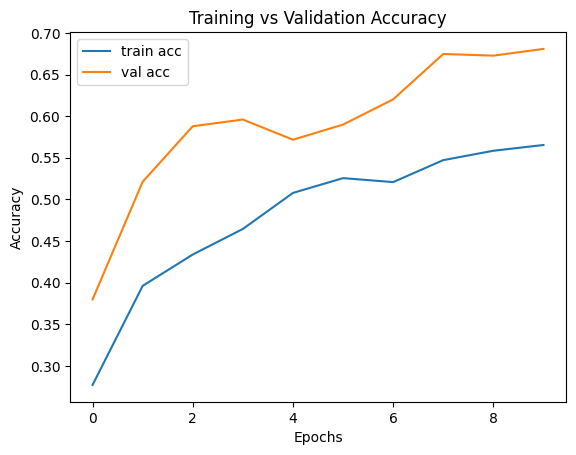

In [24]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 86s 5s/step


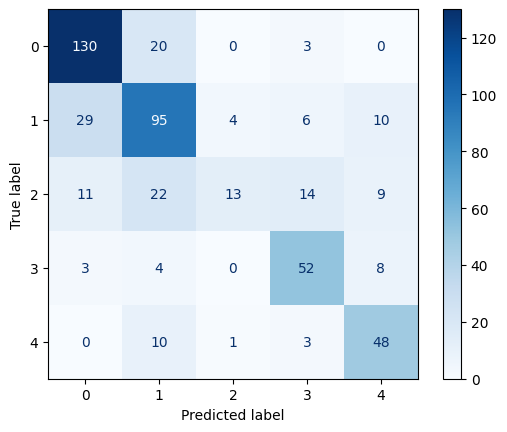

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

y_pred = model.predict(X_test)
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')


In [26]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))


              precision    recall  f1-score   support

           0       0.75      0.85      0.80       153
           1       0.63      0.66      0.64       144
           2       0.72      0.19      0.30        69
           3       0.67      0.78      0.72        67
           4       0.64      0.77      0.70        62

    accuracy                           0.68       495
   macro avg       0.68      0.65      0.63       495
weighted avg       0.69      0.68      0.66       495



In [30]:
model.save("resnet_knee_grading_model.keras")
